# Import Library

In [1]:
import os
import sys
import random
import pandas as pd
import numpy as np
#import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
## Seeding 

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2023)


seed = 2023
random.seed = 2023
np.random.seed = 2023
tf.seed = 2023
tf.random.set_seed(2023)


from tensorflow.keras import backend as K
K.clear_session()

# Data processing

In [2]:
import scipy.io as scio
import pandas as pd

#input
feature1 = r'\Training dataset\ACC_EW.mat'
data1 = scio.loadmat(feature1)
AA=data1['ACC_EW']
A=AA[:,0:300]

feature2 = r'\Training dataset\ACC_NS.mat'
data2 = scio.loadmat(feature2)
BB=data2['ACC_NS']
B=BB[:,0:300]

feature3 = r'\Training dataset\ACC_UD.mat'
data3 = scio.loadmat(feature3)
CC=data3['ACC_UD']
C=CC[:,0:300]


label = pd.read_csv(open(r'\Training dataset\lable.csv',encoding='UTF-8'))


In [3]:
raw_data1=np.hstack((A,B))
train_xx=np.hstack((raw_data1,C))

#print(train_xx.shape)


train_y=label.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(train_y[0])
#print(train_y.shape)

In [4]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(3,1,300)).T)

In [5]:
train_x=np.array(train_x)

In [6]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 3))
#print("0",train_x.shape[0])
#print("1",train_x.shape[1])
#print(train_x.shape)
#print(train_x)

# EqViT architecture, training and testing

In [7]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.python.keras.layers import Layer

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

In [8]:
class DecoderLayer():
    def __init__(self,d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.dec_enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, enc_outputs, dec_self_attn_mask=None, dec_enc_attn_mask=None):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs

In [9]:

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn
    
    
    
    
    

In [10]:
def CNN(x):
    e = Conv1D(64, 3, padding = 'same')(x) 
    e = Dropout(0.1)(e)
    e = MaxPooling1D(2, padding='same')(e)
    
    e = Conv1D(32, 3, padding = 'same')(e) 
    e = Dropout(0.1)(e) 
    e = MaxPooling1D(2, padding='same')(e)

    e = Conv1D(32, 3, padding = 'same')(e) 
    e = Dropout(0.1)(e) 
    e = MaxPooling1D(2, padding='same')(e)
    
    e = Conv1D(32, 3, padding = 'same')(e) 
    e = Dropout(0.1)(e) 
    e = MaxPooling1D(5, padding='same')(e)



    return e

In [11]:
###第一种 -Safty
input_shape=(8, 32)
def Transformer_Econder(inputs):
    
    # Normalization and Attention
    x = LayerNormalization()(inputs)
    x, slf_attn = MultiHeadAttention(n_head=3, d_model=32, d_k=64, d_v=64, dropout=0.1)(x, x, x)  #n_head=3 d_model=128  d_k=64, d_v=64
    res = x + inputs
    
    # Feed Forward Pasrt
    x = LayerNormalization()(res)
    x = tf.keras.layers.Dense(2*inputs.shape[-1])(x) 
    x = tf.keras.layers.Dense(inputs.shape[-1])(x)
    
    return x + res


In [12]:
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets
seed=50
#50 17.20 1.32
drop_rate = 0.2
def get_model():

    inp1 = Input(shape=(300, 3), name='input_layer')
    
    x = CNN(inp1)
    positions = tf.keras.layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(tf.range(input_shape[0], dtype=tf.float32))
    x = x + positions 
    
    x = Transformer_Econder(x)
    x = Transformer_Econder(x)
    x = Transformer_Econder(x)
    x = Transformer_Econder(x)

    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = tf.keras.layers.Concatenate()([avg_pool, max_pool])
       
         
    #conc = tf.keras.layers.Dropout(rate=0.5)(conc)  #rate=0.2
    conc = tf.keras.layers.Dense(100, activation="relu")(conc)   #256
    conc = tf.keras.layers.Dense(50, activation="relu")(conc)   #256

    output = tf.keras.layers.Dense(1,dtype='float32')(conc) 
    

    e = Dense(1)(output)
    o = Activation('linear', name='output_layer')(e)
    

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model(inp1, o)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [13]:
model = get_model()
model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 300, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 64)      640         input_layer[0][0]                
__________________________________________________________________________________________________
dropout (Dropout)               (None, 300, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 150, 64)      0           dropout[0][0]                    
_______________________________________________________________________________________

In [14]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(33)
#np.random.seed(seed)
#random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

pred_train_all=np.zeros(train_y.shape)
#pred_test_all = np.zeros(test_y.shape)
#pred_zhenli_all = np.zeros(y_zhenli.shape)

    
#es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)


In [15]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
model.fit(train_x, train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict(train_x).ravel()
#pred_test_all = model.predict(test_x).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

Epoch 1/300
162/162 [==============================] - 12s 75ms/step - loss: 0.9299 - val_loss: 0.3820
Epoch 2/300
162/162 [==============================] - 10s 62ms/step - loss: 0.3625 - val_loss: 0.3102
Epoch 3/300
162/162 [==============================] - 10s 64ms/step - loss: 0.3320 - val_loss: 0.3174
Epoch 4/300
162/162 [==============================] - 10s 64ms/step - loss: 0.2988 - val_loss: 0.2746
Epoch 5/300
162/162 [==============================] - 11s 66ms/step - loss: 0.2870 - val_loss: 0.2695
Epoch 6/300
162/162 [==============================] - 11s 65ms/step - loss: 0.2790 - val_loss: 0.2497
Epoch 7/300
162/162 [==============================] - 11s 65ms/step - loss: 0.2778 - val_loss: 0.2517
Epoch 8/300
162/162 [==============================] - 10s 62ms/step - loss: 0.2639 - val_loss: 0.2405
Epoch 9/300
162/162 [==============================] - 10s 64ms/step - loss: 0.2691 - val_loss: 0.2494
Epoch 10/300
162/162 [==============================] - 15s 91ms/step - l

Epoch 80/300
162/162 [==============================] - 11s 69ms/step - loss: 0.1490 - val_loss: 0.1665


In [16]:
# 保存权重（推荐方式）
model.save_weights("EqViT_weights.h5")  # HDF5格式

In [17]:
def get_model_size_mb(model):
    params = model.count_params()
    # 假设所有参数为float32（4字节）
    size_mb = params * 4 / 1024**2
    return size_mb
 
print("Model size (MB):", get_model_size_mb(model))

Model size (MB): 0.5363273620605469


训练标准差STD= 0.37203695149671573
训练误差均值MEAN= 0.0013028702401050695
训练平均绝对误差MAE= 0.2778045649333823
训练RMSE= 0.3720392328099714
训练MAPE= 6.390043619575546
训练r2 score: 0.8649385025001204


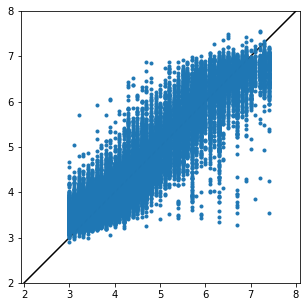

In [18]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()

In [19]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
#print(pred_train_all.shape)
#print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

#print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['True M','Pred M']
writer_tr = pd.ExcelWriter(r'\EqViT\magtrain.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

In [20]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\Test dataset\ACC_EW.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_EW']
Az=AAz[:,0:300]

feature2z = r'\Test dataset\ACC_NS.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_NS']
Bz=BBz[:,0:300]

feature3z = r'\Test dataset\ACC_UD.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_UD']
Cz=CCz[:,0:300]



labelz = pd.read_csv(open(r'\Test dataset\lable.csv',encoding='UTF-8'))


In [21]:
raw_data1z=np.hstack((Az,Bz))
x_dataz=np.hstack((raw_data1z,Cz))


zhenli_y=labelz.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(zhenli_y[0])
#print(zhenli_y.shape)

In [22]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(3,1,300)).T)

In [23]:
zhenli_x=np.array(zhenli_x)

In [24]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 3))

In [24]:
zhenli_x1=zhenli_x[0]
zhenli_x1=zhenli_x1.reshape(1, 300, 3)
print(zhenli_x1.shape)

(1, 300, 3)


In [26]:
import time
start_time = time.perf_counter()  # 记录开始时间
pred_zhenli_all = model.predict(zhenli_x1).ravel()  ##ravel() 转换成1列
end_time = time.perf_counter()  # 记录结束时间
elapsed_time_ms = (end_time - start_time) * 1000  # 转换为毫秒
print(f"Elapsed time: {elapsed_time_ms:.2f} ms")

Elapsed time: 38.97 ms


震例标准差STD= 0.38747093077814887
震例误差均值MEAN= -0.04418610497072792
震例平均绝对误差MAE= 0.2941366671344599
震例RMSE= 0.3899822227622295
震例MAPE= 6.826250086229252
震例r2 score: 0.8419009316208905


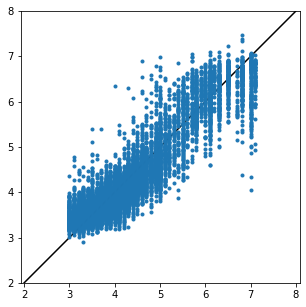

In [25]:
pred_zhenli_all = model.predict(zhenli_x).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()  

In [26]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

#print(pred_zhenli_all.shape)
#print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

#print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['True M','Pred M']
writer_tz = pd.ExcelWriter(r'\EqViT\magtest.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

# Test on the Chinese strong-ground motion data

In [27]:
#在中国地区的测试
import scipy.io as scio
import pandas as pd

#input
feature1z_CH = r'\Chinese strong-ground motion test dataset\ACC_EW.mat'
data1z_CH = scio.loadmat(feature1z_CH)
AAz_CH=data1z_CH['ACC_EW']
Az_CH=AAz_CH[:,0:300]

feature2z_CH = r'\Chinese strong-ground motion test dataset\ACC_NS.mat'
data2z_CH = scio.loadmat(feature2z_CH)
BBz_CH=data2z_CH['ACC_NS']
Bz_CH=BBz_CH[:,0:300]

feature3z_CH = r'\Chinese strong-ground motion test dataset\ACC_UD.mat'
data3z_CH = scio.loadmat(feature3z_CH)
CCz_CH=data3z_CH['ACC_UD']
Cz_CH=CCz_CH[:,0:300]



labelz_CH = pd.read_csv(open(r'\Chinese strong-ground motion test dataset\lable.csv',encoding='UTF-8'))


In [28]:
raw_data1z_CH=np.hstack((Az_CH,Bz_CH))
x_dataz_CH=np.hstack((raw_data1z_CH,Cz_CH))


zhenli_y_CH=labelz_CH.iloc[:,[3]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
#print(zhenli_y_CH[0])
#print(zhenli_y_CH.shape)

In [29]:
zhenli_x_CH=[]
for i in range(len(x_dataz_CH)):
    zhenli_x_CH.append(np.array(x_dataz_CH[i].reshape(3,1,300)).T)

In [30]:
zhenli_x_CH=np.array(zhenli_x_CH)

In [31]:
zhenli_x_CH = np.reshape(zhenli_x_CH, (zhenli_x_CH.shape[0], 300, 3))

震例标准差STD= 0.5188009464507606
震例误差均值MEAN= 0.2644566304850314
震例平均绝对误差MAE= 0.4405533185120426
震例RMSE= 0.582315834788735
震例MAPE= 10.099415416523696
震例r2 score: 0.4704481759452128


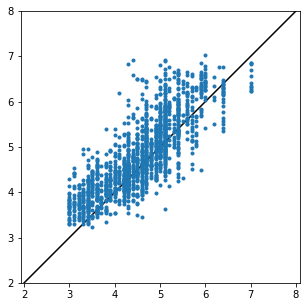

In [32]:
pred_zhenli_all_CH = model.predict(zhenli_x_CH).ravel()  ##ravel() 转换成1列
print("震例标准差STD=",np.std(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all_CH-zhenli_y_CH.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all_CH, zhenli_y_CH.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all_CH, zhenli_y_CH.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y_CH.ravel() - pred_zhenli_all_CH) / zhenli_y_CH.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y_CH.ravel(), pred_zhenli_all_CH))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(2, 8, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y_CH.ravel(),pred_zhenli_all_CH,'.')
plt.xlim(2, 8)
plt.ylim(2, 8)
plt.show()  